# Import Libraries 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Set up GPU

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device =='cuda':
    print('Training on GPU......')
else: 
    print('Training on CPU......')

Training on GPU......


# Load image

In [3]:
def load_image(image_path, image_hight = 400, image_length = 300):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
                transforms.Resize((image_length, image_hight)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = transform(image)[:3,:,:].unsqueeze(0)
    return image.to(device)

In [4]:
# load dfferent content and style image

# content_img = torch.tensor(load_image("content/content1.jpeg"))
# content_img = torch.tensor(load_image("content/duke_chapel.jpeg"))
# content_img = torch.tensor(load_image("content/snoopy.png", image_hight = 400, image_length = 400))
# content_img = torch.tensor(load_image("content/ocean.png"))
# content_img = torch.tensor(load_image("content/ocean2.jpeg"))
# content_img = torch.tensor(load_image("content/mountain.jpeg"))
content_img = torch.tensor(load_image("content/stars.jpeg"))

style_img = torch.tensor(load_image("style/star.jpeg"))
# style_img = torch.tensor(load_image("style/wassily.jpeg"))
# style_img = torch.tensor(load_image("style/blue.png"))
# style_img = torch.tensor(load_image("style/Tsunami.jpeg"))
# style_img = torch.tensor(load_image("style/iris.jpg"))
# style_img = torch.tensor(load_image("style/shanshui.png"))
# style_img = torch.tensor(load_image("style/scream.png"))
# style_img = torch.tensor(load_image("style/shipwreck.jpeg"))
# style_img = torch.tensor(load_image("style/picassow.jpeg"))


# Define image printing function

In [5]:
def print_image(tensor):    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

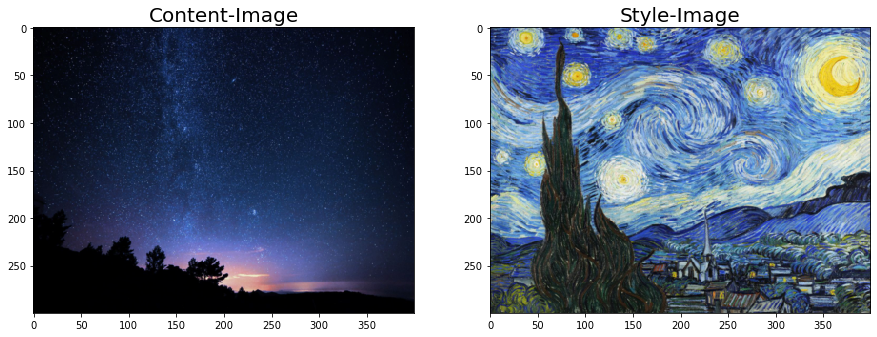

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.imshow(print_image(content_img))
ax1.set_title("Content-Image",fontsize = 20)
ax2.imshow(print_image(style_img))
ax2.set_title("Style-Image", fontsize = 20)
plt.show()
save_image(content_img, "content.png")
save_image(style_img, "style.png")

# Load pretrained VGG19 model

In [7]:
vgg = models.vgg19(pretrained=True).features

# change maximum pooling operation to average pooling for more appealing results
for n, layer in vgg.named_children():
    if isinstance(layer, torch.nn.MaxPool2d):
        vgg[int(n)] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

for param in vgg.parameters():
    param.requires_grad_(False)
    
vgg.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/jovyan/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (19): Conv2d(256

# Select features from specific layers 

In [8]:
def get_features(image, model):
    
    # based on the VGG19 structure, select specific layers 
    layers = {'0': 'conv1_1',
              '5': 'conv2_1', 
#               '7': 'conv2_2', # content comparison
              '10': 'conv3_1', 
              '19': 'conv4_1',
              '21': 'conv4_2', #content
              '28': 'conv5_1'}
        
    features = {}
    
    x = image
    
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features


Total loss:  243519.96875


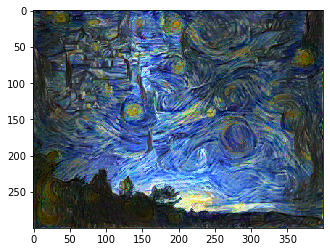

Total loss:  228023.625


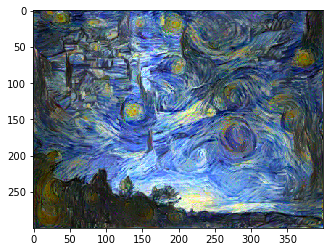

Total loss:  224425.0625


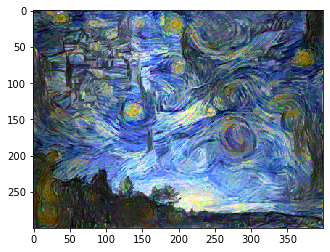

Total loss:  222169.453125


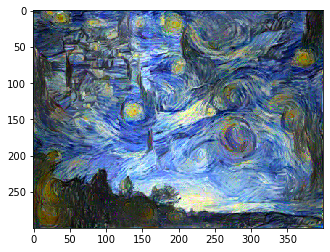

In [9]:
show = 5000

generated = content_img.clone().requires_grad_(True)
# generated = style_img.clone().requires_grad_(True)
# generated = torch.randn(content_img.data.shape, device=device, requires_grad=True) 

# Hyperparameters
total_steps =20000
style_weights = {'conv1_1': 0.2,
                 'conv2_1': 0.2,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}
learning_rate = 0.01
alpha = 1
beta = 1e5

optimizer = optim.Adam([generated], lr=learning_rate)


for i in range(1, total_steps+1):
    content_features = get_features(content_img, vgg)
    style_features = get_features(style_img, vgg)
    generated_features = get_features(generated, vgg)
    
    # compute content loss on conv4_2 layer
    content_loss = torch.sum((generated_features['conv4_2'] - content_features['conv4_2']) ** 2)/2
    
    # compute style loss from layers conv1_1, conv2_1, conv3_1, conv4_1, and conv5_1
    style_loss = 0
    for layer in style_weights:
        
        generated_feature = generated_features[layer]
        
        # get the shape of tensor
        _, channel, height, width = generated_feature.shape
       
        # compute generated gram matrix
        generated_feature = generated_feature.view(channel, height * width)
        G = torch.mm(generated_feature, generated_feature.t())
        
        # compute style gram matrix
        style_feature = style_features[layer].view(channel, height * width)
        A = torch.mm(style_feature, style_feature.t())         
        
        # compute each layer style loss
        layer_style_loss = style_weights[layer] * torch.sum((G - A)**2)/ (4 * 3**2 * height**2 * width**2)
        style_loss += layer_style_loss 
             
    total_loss = alpha * content_loss + beta * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if  i % show == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(print_image(generated))
        plt.show()
        


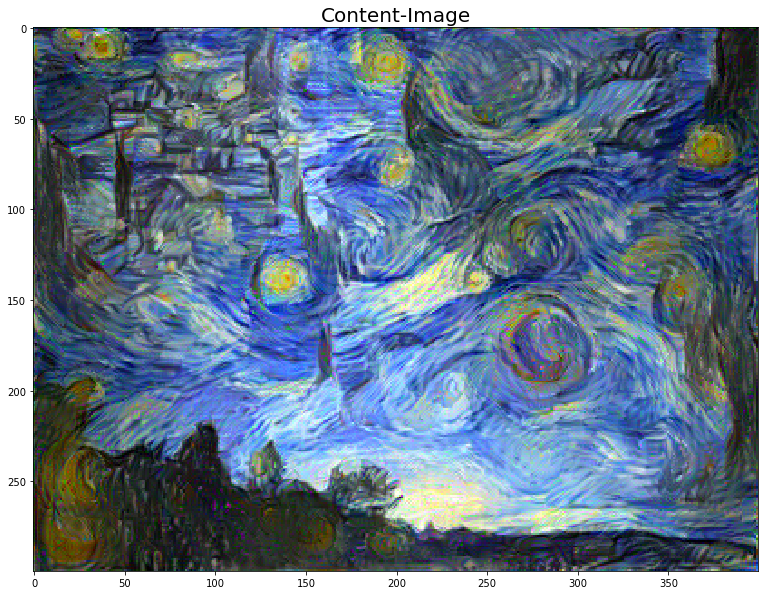

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
ax.imshow(print_image(generated))
ax.set_title("Content-Image",fontsize = 20)
plt.show()

